### Table of Content
##### [1.Loading Data](#loaddata)

[1.1Transaction Data](#transc_data)

[1.2Memeber Data](#memb_data)

[1.3User Logs](#user_log)

[2.Feature Engineering](#feature)

[3.Simple Modeling](#simplemodel)

[4.Ensemble Modeling](#ensmbmodel)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print ("read training set, test set")
train = pd.read_csv('data/train_v2.csv').set_index('msno')
test = pd.read_csv('data/sample_submission_v2.csv').set_index('msno')
test['is_churn'] = np.nan

read training set, test set


In [3]:
print ("read trasaction set, test set")
transc1 = pd.read_csv('data/transactions.csv',parse_dates=['transaction_date','membership_expire_date']).set_index('msno')
transc2 = pd.read_csv('data/transactions_v2.csv',parse_dates=['transaction_date','membership_expire_date']).set_index('msno')
transc = pd.concat([transc1,transc2],axis=0,ignore_index=False)
print ('total transaction entities {:d}'.format(transc.shape[0]))
print ('columns name')
print (transc.columns)

read trasaction set, test set
total transaction entities 22978755
columns name
Index(['payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_auto_renew', 'transaction_date',
       'membership_expire_date', 'is_cancel'],
      dtype='object')


In [4]:
def add_transaction_count(data,transc):
    print ('adding_transaction_count...')
    temp = (transc1['transaction_date'].reset_index().groupby('msno').count()
            .rename(index=str,columns={'transaction_date':'transc_counts'}))
    data = pd.merge(data,temp,left_index=True,right_index=True,how='left')
    return data
def add_last_transc_days_from_now(data,transc,end_date):
    print ('adding_last_transc_days_from_now...')
    temp = (transc['transaction_date'].reset_index().sort_values('transaction_date')
            .drop_duplicates('msno',keep='last').set_index('msno')
            .rename(index=str,columns={'transaction_date':'latest_transc_date'}))
    temp['end_date'] = end_date
    temp['days_since_last_transc'] = (temp.end_date-temp.latest_transc_date).dt.days
    data = pd.merge(data,temp['days_since_last_transc'].to_frame(),left_index=True,right_index=True,how='left')
    return data
def add_first_transc_days_from_now(data,transc,end_date):
    print ('adding_first_transc_days_from_now...')
    temp = (transc['transaction_date'].reset_index().sort_values('transaction_date')
            .drop_duplicates('msno',keep='first').set_index('msno')
            .rename(index=str,columns={'transaction_date':'first_transc_date'}))
    temp['end_date'] = end_date
    temp['days_since_first_transc'] = (temp.end_date-temp.first_transc_date).dt.days
    data = pd.merge(data,temp['days_since_first_transc'].to_frame(),left_index=True,right_index=True,how='left')    
    return data
def add_member_expire_days_from_now(data,transc,end_date):
    print ('adding_member_expire_from_now...')
    temp = (transc['membership_expire_date'].reset_index().sort_values('membership_expire_date')
            .drop_duplicates('msno',keep='last').set_index('msno'))
    temp['end_date'] = end_date
    temp['days_till_member_expire'] = (temp.membership_expire_date-temp.end_date).dt.days
    data = pd.merge(data,temp['days_till_member_expire'].to_frame(),left_index=True,right_index=True,how='left')  
    return data
def add_latest_transaction_features(data,transc):
    print ('adding_transaction_features...')
    temp = (transc.reset_index().sort_values('transaction_date')
            .drop_duplicates('msno',keep='last').set_index('msno'))
    data = pd.merge(data,temp,left_index=True,right_index=True,how='left')  
    data = data.drop(columns=['membership_expire_date','transaction_date'])
    return data

In [5]:
from datetime import datetime
train_end = datetime(year=2017,month=2,day=28)
test_end = datetime(year=2017,month=3,day=31)
print ('merge trainsaction data...')
data = [train,test]
trans = [transc1,transc]
end_date = [train_end,test_end]
for i in range(2):
    data[i] = add_member_expire_days_from_now(data[i],trans[i],end_date[i])
    data[i] = add_transaction_count(data[i],trans[i])
    data[i] = add_last_transc_days_from_now(data[i],trans[i],end_date[i])
    data[i] = add_first_transc_days_from_now(data[i],trans[i],end_date[i])
    data[i] = add_latest_transaction_features(data[i],trans[i])

merge trainsaction data...
adding_member_expire_from_now...
adding_transaction_count...
adding_last_transc_days_from_now...
adding_first_transc_days_from_now...
adding_transaction_features...
adding_member_expire_from_now...
adding_transaction_count...
adding_last_transc_days_from_now...
adding_first_transc_days_from_now...
adding_transaction_features...


In [6]:
train_data = data[0].dropna()
test_data = data[0].dropna()

### Load Member data

In [7]:
member = pd.read_csv('data/members_v3.csv',parse_dates=['registration_init_time'])
all_member = pd.concat([train,test],axis=0).reset_index().drop_duplicates('msno').drop(columns=['is_churn'])
all_member = pd.merge(all_member,member,on='msno',how='left').set_index('msno')
print ("total member data entities {:d}".format(all_member.shape[0]))
print (all_member.columns)
print (all_member.isnull().sum())

total member data entities 1076941
Index(['city', 'bd', 'gender', 'registered_via', 'registration_init_time'], dtype='object')
city                      120376
bd                        120376
gender                    641415
registered_via            120376
registration_init_time    120376
dtype: int64


In [8]:
#filling missing value
all_member.loc[(all_member.bd>100) | (all_member.bd<0) | all_member.bd.isnull(),'bd'] = 0
all_member.loc[all_member.city.isnull(),'city'] = all_member.city.value_counts().index[0]
all_member.loc[all_member.registered_via.isnull(),'registered_via'] = all_member.registered_via.value_counts().index[0]
all_member.loc[all_member.gender.isnull(),'gender']='unknow'
all_member = all_member.drop(columns=['registration_init_time'])

In [9]:
train_data = pd.merge(train_data,all_member,right_index=True,left_index=True,how='left')
test_data = pd.merge(test_data,all_member,right_index=True,left_index=True,how='left')

In [10]:
train_data.head()

,is_churn,days_till_member_expire,transc_counts,days_since_last_transc,days_since_first_transc,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,city,bd,gender,registered_via
msno,,,,,,,,,,,,,,,
ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,30.0,6.0,0.0,700.0,38.0,30.0,149.0,149.0,0.0,0.0,5.0,28.0,male,3.0
f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,12.0,5.0,18.0,362.0,36.0,30.0,180.0,180.0,0.0,0.0,13.0,20.0,male,3.0
zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,7.0,18.0,29.0,559.0,38.0,30.0,149.0,149.0,0.0,0.0,13.0,18.0,male,3.0
8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,8.0,19.0,369.0,782.0,35.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,unknow,7.0
K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,5.0,24.0,180.0,766.0,41.0,30.0,99.0,99.0,1.0,0.0,13.0,35.0,female,7.0


### User Logs

In [11]:
users_msno = list(all_member.index)
user_logs2 = pd.read_csv('data/user_logs_v2.csv',parse_dates=['date'])

In [15]:
def read_log_chunk(path,chunksize=None,period=[None,None],users_msno=None):
    import time
    reader = pd.read_csv(path,parse_dates=['date'], iterator=True)
    i = 0
    n_total = 0
    chunks = []
    loop = True
    start = time.time()
    while loop:
        try:
            i+=1
            print ('===reading {:d}th chunks==='.format(i))
            chunk = reader.get_chunk(chunksize)
            #date filter
            ma1 = ((chunk.date>train_start)&(chunk.date<train_end))
            if ma1.sum()>0:
                chunk = chunk.loc[ma1,:]
                #msno filter
                ma2 = chunk.msno.isin(users_msno)
                if ma2.sum()>0:
                    n_total += ma2.sum()
                    print ('chunk data read = {:d}'.format(ma2.sum()))
                    chunk = chunk.loc[ma2,:]
                    chunks.append(chunk)
                else:pass
            else:pass
            dt = time.time()-start
            print ('total data read = {:d}'.format(n_total))
            print ('time escape {:f}'.format(dt))
        except StopIteration:
            loop = False
            print ("Iteration is stopped.")
    user_logs = pd.concat(chunks, ignore_index=True) 
    return user_logs
users_msno = list(all_member.index)
train_end = datetime(year=2017,month=2,day=28)
train_start = datetime(year=2017,month=1,day=28)
user_logs1 = read_log_chunk('data/user_logs.csv',chunksize=10000000,period=[train_start,train_end],users_msno=users_msno)

===reading 1th chunks===
chunk data read = 348239
total data read = 348239
time escape 16.342952
===reading 2th chunks===
chunk data read = 348050
total data read = 696289
time escape 32.898935
===reading 3th chunks===
chunk data read = 346888
total data read = 1043177
time escape 49.344462
===reading 4th chunks===
chunk data read = 347672
total data read = 1390849
time escape 65.743793
===reading 5th chunks===
chunk data read = 347783
total data read = 1738632
time escape 82.764907
===reading 6th chunks===
chunk data read = 347488
total data read = 2086120
time escape 99.086257
===reading 7th chunks===
chunk data read = 347233
total data read = 2433353
time escape 114.500588
===reading 8th chunks===
chunk data read = 347466
total data read = 2780819
time escape 129.380491
===reading 9th chunks===
chunk data read = 346872
total data read = 3127691
time escape 143.934472
===reading 10th chunks===
chunk data read = 347176
total data read = 3474867
time escape 159.266035
===reading 11th c

In [16]:
def add_user_stats_feature(data,user_logs):
    temp = (user_logs.groupby('msno').agg({'date':'count',
                                           'num_25':['max','median','sum'],
                                           'num_50':['max','median','sum'],
                                           'num_985':['max','median','sum'],
                                           'num_100':['max','median','sum'],
                                           'num_unq':['max','median','sum'],
                                           'total_secs':['max','median','sum']}))
    temp.columns = ["_".join(x) for x in temp.columns.ravel()]
    data = pd.merge(data,temp,left_index=True,right_index=True,how='left')
    data = data.drop(columns=['is_churn'])
    data = data.fillna(0)
    return data
data = [train,test]
user_log = [user_logs1,user_logs2]
for i in range(2):
    data[i] = add_user_stats_feature(data[i],user_log[i])
train_data = pd.merge(train_data,data[0],right_index=True,left_index=True,how='left')
test_data = pd.merge(test_data,data[1],right_index=True,left_index=True,how='left')
train_data.fillna(value=0,inplace=True)
test_data.fillna(value=0,inplace=True)
train_data.head()

In [20]:
train_data.reset_index().to_csv('training_feature_v2.csv',index=False)
test_data.reset_index().to_csv('testing_feature_v2.csv',index=False)

### Encodeing

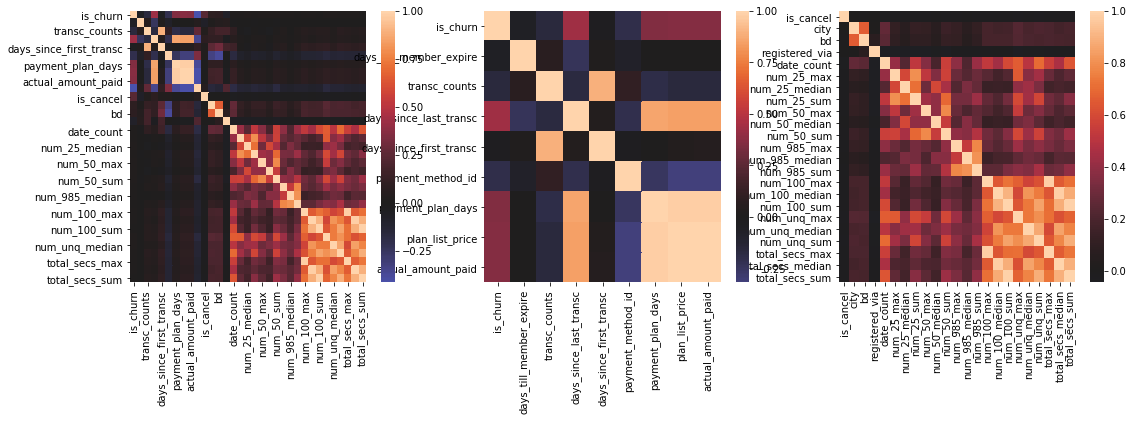

In [28]:
corr_matrix = train_data.corr()
f, axes = plt.subplots(1,3,figsize=(18,5))
ax1 = sns.heatmap(corr_matrix,center=0,ax=axes[0])
ax2 = sns.heatmap(corr_matrix.iloc[:9,:9],center=0,ax=axes[1])
ax3 = sns.heatmap(corr_matrix.iloc[10:,10:],center=0,ax=axes[2])

#### Check Point

In [2]:
train_data = pd.read_csv('training_feature_v2.csv')
test_data  = pd.read_csv('testing_feature_v2.csv')

from sklearn.preprocessing import LabelEncoder
catagory = ['payment_method_id', 'payment_plan_days', 'plan_list_price','actual_amount_paid', 'city','gender', 'registered_via']
encoder = {}
for c in catagory:
    print (c)
    le = LabelEncoder()
    le.fit(pd.concat([train_data[c],test_data[c]],axis=0))
    name = c+'_encoded'
    train_data[name]= le.transform(train_data.loc[:,c])
    test_data[name]= le.transform(train_data.loc[:,c])
    encoder[c] = le

X = train_data.drop(columns=catagory)
Y = test_data.drop(columns=catagory)
X.drop(columns='msno',inplace=True)
Y.drop(columns='msno',inplace=True)
X = X.iloc[:,1:].values
Y = Y.iloc[:,0].values

payment_method_id
payment_plan_days
plan_list_price
actual_amount_paid
city
gender
registered_via


### Modeling

In [3]:
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from xgboost import plot_importance
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)
lloss = accuracy_score(y_test, np.zeros_like(y_test))
print("Null LogLoss:  {:.4f}".format(lloss))

Null LogLoss:  0.9111


[0]	validation_0-logloss:0.61672	validation_1-logloss:0.616949
[1]	validation_0-logloss:0.552945	validation_1-logloss:0.553335
[2]	validation_0-logloss:0.499228	validation_1-logloss:0.499867
[3]	validation_0-logloss:0.455107	validation_1-logloss:0.455991
[4]	validation_0-logloss:0.417839	validation_1-logloss:0.418927
[5]	validation_0-logloss:0.384968	validation_1-logloss:0.386277
[6]	validation_0-logloss:0.356778	validation_1-logloss:0.358271
[7]	validation_0-logloss:0.332204	validation_1-logloss:0.333828
[8]	validation_0-logloss:0.310826	validation_1-logloss:0.312685
[9]	validation_0-logloss:0.292253	validation_1-logloss:0.294368
[10]	validation_0-logloss:0.276436	validation_1-logloss:0.27875
[11]	validation_0-logloss:0.261703	validation_1-logloss:0.264201
[12]	validation_0-logloss:0.249627	validation_1-logloss:0.252291
[13]	validation_0-logloss:0.238219	validation_1-logloss:0.241018
[14]	validation_0-logloss:0.228771	validation_1-logloss:0.231729
[15]	validation_0-logloss:0.220097	va

/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 94.68%
LogLoss:  0.1573
Total Time 288.29


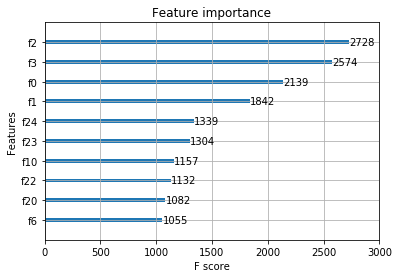

In [4]:
start = time.time()
xgb = XGBClassifier(learning_rate=0.1,
                    max_depth=10,
                    min_child_weight=6,
                    n_estimator=1000,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    reg_alpha=0.005,
                    objective='binary:logistic',
                    nthreads=-1)
xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='logloss',
        verbose=1)

y_pred_proba = xgb.predict_proba(X_test)
logloss = log_loss(y_test,y_pred_proba)
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
elapsed = time.time() - start
print("Accuracy: {:.2f}%".format(accuracy * 100.0))
print("LogLoss:  {:.4f}".format(logloss))
print("Total Time {:.2f}".format(elapsed ))
plot_importance(xgb,max_num_features=10)

In [ ]:
import scipy.stats as st
n_iter_search = 30
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)
params = {  
    "n_estimators": st.randint(100, 1000),
    "max_depth": st.randint(5, 20),
    "learning_rate": st.uniform(0.01, 0.2),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}
xgb_rscv = XGBClassifier(nthreads=1)
random_search = RandomizedSearchCV(xgb_rscv,
                                   param_distributions=params,
                                   cv=3,
                                   scoring='neg_log_loss',
                                   n_iter=n_iter_search,
                                   random_state=0,
                                   n_jobs=-1,
                                   verbose=1)
random_search.fit(X_train, y_train)  

In [8]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8976997421479328, gamma=3.394038194495186,
       learning_rate=0.10790978737821874, max_delta_step=0, max_depth=10,
       min_child_weight=11.156960372207223, missing=None, n_estimators=136,
       n_jobs=1, nthread=None, nthreads=1, objective='binary:logistic',
       random_state=0, reg_alpha=9.37594791679631, reg_lambda=1,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7833006708474917)

In [ ]:
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred_proba = best_model.predict_proba(X_test)
logloss = log_loss(y_test,y_pred_proba)
y_pred = best_model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)

Accuracy: 94.66%
LogLoss:  0.1575


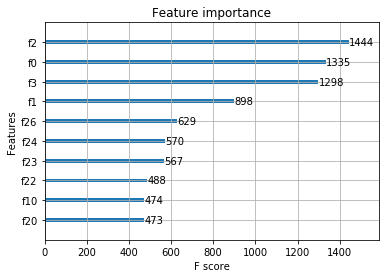

In [11]:
print("Accuracy: {:.2f}%".format(accuracy * 100.0))
print("LogLoss:  {:.4f}".format(logloss))
plot_importance(best_model,max_num_features=10,ticks_label)

### Prediction